# IMDB 영화 리뷰 데이터셋 처리 및 감성 분석

## 개요
이 노트북에서는 Stanford AI Lab의 IMDB 영화 리뷰 데이터셋을 활용하여 감성 분석을 위한 데이터 전처리 과정을 학습합니다.
대용량 실제 데이터셋을 다운로드하고, 전처리하며, Keras의 데이터 로딩 기능을 활용하는 전체 파이프라인을 구현합니다.

## 학습 목표
1. 실제 대용량 데이터셋 다운로드 및 처리 방법 학습
2. 데이터셋 구조 이해 및 전처리 과정 구현
3. Train/Validation/Test 데이터 분할 전략
4. Keras dataset_from_directory 활용법
5. 실제 NLP 프로젝트 데이터 파이프라인 구축

## 데이터셋 정보
- **출처**: Stanford AI Lab (Andrew Maas et al.)
- **크기**: ~80MB (압축), ~280MB (압축 해제)
- **구성**: 50,000개 영화 리뷰 (긍정/부정 각 25,000개)
- **분할**: Train(25,000) + Test(25,000) + Unsupervised(50,000)
- **레이블**: Binary classification (긍정/부정)
- **URL**: https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

## 1. 필요한 라이브러리 임포트

In [2]:
import requests
import subprocess
import re
import string
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import keras
import os
import pathlib
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import time

print(f"TensorFlow 버전: {tf.__version__}")
print(f"Keras 버전: {keras.__version__}")
print(f"Python 버전: {os.sys.version}")

TensorFlow 버전: 2.15.1
Keras 버전: 2.15.0
Python 버전: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:39:58) [MSC v.1943 64 bit (AMD64)]


## 2. 데이터셋 다운로드 함수 구현

대용량 파일을 효율적으로 다운로드하기 위한 스트리밍 방식을 사용합니다.

In [3]:
def download_imdb_dataset():
    """
    IMDB 데이터셋을 다운로드하는 함수
    
    특징:
    - 스트리밍 방식으로 메모리 효율적 다운로드
    - 8KB 청크 단위로 진행상황 표시
    - 이미 파일이 존재하면 다운로드 건너뛰기
    """
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    file_name = "aclImdb_v1.tar.gz"
    
    # 파일이 이미 존재하는지 확인
    if os.path.exists(file_name):
        file_size = os.path.getsize(file_name) / (1024 * 1024)  # MB 단위
        print(f"파일이 이미 존재합니다: {file_name} ({file_size:.1f}MB)")
        return
    
    print(f"데이터셋 다운로드 시작: {url}")
    print("파일 크기가 큽니다. 시간이 소요될 수 있습니다...")
    
    try:
        # 스트리밍 방식으로 다운로드
        response = requests.get(url, stream=True)
        response.raise_for_status()  # HTTP 에러 체크
        
        # 전체 파일 크기 확인 (가능한 경우)
        total_size = int(response.headers.get('content-length', 0))
        downloaded = 0
        
        with open(file_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):  # 8KB씩 다운로드
                if chunk:  # 빈 청크 필터링
                    file.write(chunk)
                    downloaded += len(chunk)
                    
                    # 진행률 표시 (전체 크기를 알 수 있는 경우)
                    if total_size > 0:
                        progress = (downloaded / total_size) * 100
                        print(f"\r다운로드 진행률: {progress:.1f}% ({downloaded/(1024*1024):.1f}MB/{total_size/(1024*1024):.1f}MB)", end="")
        
        print(f"\n다운로드 완료! 파일 크기: {downloaded/(1024*1024):.1f}MB")
        
    except requests.RequestException as e:
        print(f"다운로드 실패: {e}")
        if os.path.exists(file_name):
            os.remove(file_name)
        raise

# 주의: 실제 다운로드는 시간이 오래 걸립니다 (수 분)
# 테스트 시에는 주석 처리해두세요
# download_imdb_dataset()

## 3. 압축 해제 함수 구현

tar.gz 형식의 압축 파일을 해제합니다.

In [4]:
def extract_archive():
    """
    tar.gz 압축 파일을 해제하는 함수
    
    tar.gz 파일 구조:
    - tar: 여러 파일을 하나의 아카이브로 묶는 형식
    - gz: gzip 압축 형식
    - Linux/Unix 계열에서 표준적인 압축 형식
    
    옵션 설명:
    - x: extract (추출)
    - v: verbose (상세 출력)
    - z: gzip 압축 해제
    - f: file (파일명 지정)
    """
    file_name = "aclImdb_v1.tar.gz"
    extract_dir = "aclImdb"
    
    # 파일 존재 확인
    if not os.path.exists(file_name):
        print(f"압축 파일이 존재하지 않습니다: {file_name}")
        print("먼저 데이터셋을 다운로드해주세요.")
        return False
    
    # 이미 압축이 해제되어 있는지 확인
    if os.path.exists(extract_dir):
        print(f"압축이 이미 해제되어 있습니다: {extract_dir}")
        return True
    
    print(f"압축 해제 시작: {file_name}")
    
    try:
        # Windows와 Unix 계열 시스템 모두 지원
        if os.name == 'nt':  # Windows
            # Windows에서는 shell=True 필요
            result = subprocess.run(["tar", "-xzf", file_name], 
                                  shell=True, 
                                  capture_output=True, 
                                  text=True)
        else:  # Unix/Linux/macOS
            result = subprocess.run(["tar", "-xzf", file_name], 
                                  capture_output=True, 
                                  text=True)
        
        if result.returncode == 0:
            print("압축 해제 완료!")
            print(f"해제된 디렉토리: {extract_dir}")
            
            # 해제된 디렉토리 구조 확인
            if os.path.exists(extract_dir):
                subdirs = [d for d in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, d))]
                print(f"하위 디렉토리: {subdirs}")
            
            return True
        else:
            print(f"압축 해제 실패: {result.stderr}")
            return False
            
    except FileNotFoundError:
        print("tar 명령어를 찾을 수 없습니다.")
        print("대안: Python의 tarfile 모듈을 사용합니다.")
        
        # Python 내장 모듈로 대체
        import tarfile
        with tarfile.open(file_name, 'r:gz') as tar:
            tar.extractall()
        print("Python tarfile 모듈로 압축 해제 완료!")
        return True
    
    except Exception as e:
        print(f"압축 해제 중 오류 발생: {e}")
        return False

# 압축 해제 테스트 (파일이 있는 경우만)
# extract_archive()

## 4. 데이터셋 구조 분석

압축 해제 후 데이터셋의 구조를 분석해봅니다.

In [13]:
def analyze_dataset_structure():
    """
    IMDB 데이터셋의 구조를 분석하는 함수
    """
    base_dir = pathlib.Path("../../data/aclImdb")
    
    if not base_dir.exists():
        print("데이터셋이 존재하지 않습니다. 먼저 다운로드하고 압축을 해제해주세요.")
        return
    
    print("=== IMDB 데이터셋 구조 분석 ===")
    print(f"기본 디렉토리: {base_dir}")
    
    # 최상위 디렉토리 구조
    top_level_dirs = [d for d in base_dir.iterdir() if d.is_dir()]
    print(f"\n최상위 디렉토리: {[d.name for d in top_level_dirs]}")
    
    # 각 디렉토리별 상세 분석
    for dir_path in top_level_dirs:
        print(f"\n📁 {dir_path.name}/")
        
        if dir_path.name in ['train', 'test']:
            # train, test 디렉토리 분석
            subdirs = [d for d in dir_path.iterdir() if d.is_dir()]
            print(f"  하위 디렉토리: {[d.name for d in subdirs]}")
            
            for subdir in subdirs:
                files = list(subdir.glob('*.txt'))
                print(f"    📂 {subdir.name}/: {len(files)}개 파일")
                
                # 샘플 파일 내용 미리보기
                if files and len(files) > 0:
                    sample_file = files[0]
                    with open(sample_file, 'r', encoding='utf-8') as f:
                        content = f.read()[:200] + "..."
                    print(f"      샘플 내용: {content}")
        
        elif dir_path.name == 'imdbEr.txt':
            # README 파일 (실제로는 파일)
            print(f"  README 파일")
    
    # 전체 통계
    train_pos = len(list((base_dir / 'train' / 'pos').glob('*.txt'))) if (base_dir / 'train' / 'pos').exists() else 0
    train_neg = len(list((base_dir / 'train' / 'neg').glob('*.txt'))) if (base_dir / 'train' / 'neg').exists() else 0
    test_pos = len(list((base_dir / 'test' / 'pos').glob('*.txt'))) if (base_dir / 'test' / 'pos').exists() else 0
    test_neg = len(list((base_dir / 'test' / 'neg').glob('*.txt'))) if (base_dir / 'test' / 'neg').exists() else 0
    
    print(f"\n=== 데이터셋 통계 ===")
    print(f"Train 긍정 리뷰: {train_pos:,}개")
    print(f"Train 부정 리뷰: {train_neg:,}개")
    print(f"Train 총합:     {train_pos + train_neg:,}개")
    print(f"")
    print(f"Test 긍정 리뷰:  {test_pos:,}개")
    print(f"Test 부정 리뷰:  {test_neg:,}개")
    print(f"Test 총합:      {test_pos + test_neg:,}개")
    print(f"")
    print(f"전체 총합:      {train_pos + train_neg + test_pos + test_neg:,}개")
    
    return {
        'train_pos': train_pos,
        'train_neg': train_neg,
        'test_pos': test_pos,
        'test_neg': test_neg
    }

# 데이터셋이 존재하는 경우 구조 분석
stats = analyze_dataset_structure()

=== IMDB 데이터셋 구조 분석 ===
기본 디렉토리: ..\..\data\aclImdb

최상위 디렉토리: ['test', 'train']

📁 test/
  하위 디렉토리: ['neg', 'pos']
    📂 neg/: 12500개 파일
      샘플 내용: Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters....
    📂 pos/: 12500개 파일
      샘플 내용: I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy....

📁 train/
  하위 디렉토리: ['neg', 'pos', 'unsup']
    📂 neg/: 12500개 파일
      샘플 내용: Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by t...
    📂 pos/: 12500개 파일
      샘플 내용: Bromwell High is a cartoon comedy. It ran at the same time as some other programs about

## 5. 샘플 데이터 탐색

실제 리뷰 데이터의 내용과 특성을 살펴봅니다.

In [15]:
def explore_sample_data(num_samples=3):
    """
    IMDB 데이터의 샘플을 탐색하는 함수
    
    Args:
        num_samples: 각 클래스에서 보여줄 샘플 수
    """
    base_dir = pathlib.Path("../../data/aclImdb")
    
    if not base_dir.exists():
        print("데이터셋이 존재하지 않습니다.")
        return
    
    print("=== IMDB 리뷰 샘플 데이터 탐색 ===")
    
    # 긍정 리뷰 샘플
    pos_dir = base_dir / 'train' / 'pos'
    if pos_dir.exists():
        pos_files = list(pos_dir.glob('*.txt'))[:num_samples]
        print(f"\n🟢 긍정 리뷰 샘플 ({len(pos_files)}개)")
        print("=" * 60)
        
        for i, file_path in enumerate(pos_files, 1):
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            
            print(f"\n📄 긍정 리뷰 #{i} (파일: {file_path.name})")
            print(f"길이: {len(content)}자")
            print(f"내용: {content[:300]}...")
            
            # 기본 통계
            words = content.split()
            sentences = content.split('.')
            print(f"단어 수: {len(words)}, 문장 수: {len(sentences)}")
    
    # 부정 리뷰 샘플
    neg_dir = base_dir / 'train' / 'neg'
    if neg_dir.exists():
        neg_files = list(neg_dir.glob('*.txt'))[:num_samples]
        print(f"\n🔴 부정 리뷰 샘플 ({len(neg_files)}개)")
        print("=" * 60)
        
        for i, file_path in enumerate(neg_files, 1):
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            
            print(f"\n📄 부정 리뷰 #{i} (파일: {file_path.name})")
            print(f"길이: {len(content)}자")
            print(f"내용: {content[:300]}...")
            
            # 기본 통계
            words = content.split()
            sentences = content.split('.')
            print(f"단어 수: {len(words)}, 문장 수: {len(sentences)}")

# 샘플 데이터 탐색 (데이터가 있는 경우)
explore_sample_data()

=== IMDB 리뷰 샘플 데이터 탐색 ===

🟢 긍정 리뷰 샘플 (3개)

📄 긍정 리뷰 #1 (파일: 0_9.txt)
길이: 806자
내용: Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insigh...
단어 수: 140, 문장 수: 28

📄 긍정 리뷰 #2 (파일: 10000_8.txt)
길이: 2366자
내용: Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worryin...
단어 수: 428, 문장 수: 13

📄 긍정 리뷰 #3 (파일: 10001_10.txt)
길이: 841자
내용: Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scenes in clothes warehouse are second to none. The corn on face is a classic, as good 

## 6. 데이터 전처리: Train/Validation 분할

Training 데이터를 Train과 Validation으로 분할합니다.

In [16]:
def create_validation_split(validation_ratio=0.2, random_seed=1337):
    """
    Training 데이터를 Train과 Validation으로 분할하는 함수
    
    Args:
        validation_ratio: Validation 데이터 비율 (기본값: 20%)
        random_seed: 재현 가능한 결과를 위한 랜덤 시드
    
    프로세스:
    1. aclImdb/val 디렉토리 생성
    2. train 데이터의 20%를 val로 이동
    3. unsup 디렉토리 제거 (라벨이 없는 데이터)
    """
    base_dir = pathlib.Path("../../data/aclImdb")
    
    if not base_dir.exists():
        print("데이터셋이 존재하지 않습니다.")
        return False
    
    val_dir = base_dir / "val"
    train_dir = base_dir / "train"
    
    # 이미 분할이 완료된 경우
    if val_dir.exists():
        print("Validation 분할이 이미 완료되어 있습니다.")
        return True
    
    print(f"데이터 분할 시작 (Validation 비율: {validation_ratio*100}%)")
    print(f"랜덤 시드: {random_seed}")
    
    try:
        # Validation 디렉토리 생성
        val_dir.mkdir(exist_ok=True)
        
        # 각 카테고리별로 처리
        for category in ["neg", "pos"]:
            print(f"\n처리 중: {category} 카테고리")
            
            # 디렉토리 생성
            (val_dir / category).mkdir(exist_ok=True)
            
            # 해당 카테고리의 모든 파일 목록 가져오기
            train_category_dir = train_dir / category
            if not train_category_dir.exists():
                print(f"  경고: {train_category_dir} 디렉토리가 존재하지 않습니다.")
                continue
            
            files = list(train_category_dir.glob('*.txt'))
            print(f"  전체 파일 수: {len(files)}")
            
            # 파일 목록을 랜덤하게 섞기
            random.Random(random_seed).shuffle(files)
            
            # Validation용 파일 개수 계산
            num_val_samples = int(validation_ratio * len(files))
            val_files = files[:num_val_samples]  # 앞에서부터 선택
            
            print(f"  Validation으로 이동할 파일 수: {num_val_samples}")
            print(f"  Train에 남을 파일 수: {len(files) - num_val_samples}")
            
            # 파일 이동
            moved_count = 0
            for file_path in val_files:
                try:
                    dest_path = val_dir / category / file_path.name
                    shutil.move(str(file_path), str(dest_path))
                    moved_count += 1
                except Exception as e:
                    print(f"  파일 이동 실패 {file_path.name}: {e}")
            
            print(f"  실제 이동된 파일 수: {moved_count}")
        
        # unsup 디렉토리 제거 (라벨이 없는 데이터)
        unsup_dir = train_dir / "unsup"
        if unsup_dir.exists():
            print(f"\nUnsupervised 데이터 디렉토리 제거: {unsup_dir}")
            shutil.rmtree(unsup_dir)
            print("제거 완료")
        
        print("\n✅ 데이터 분할 완료!")
        
        # 분할 결과 확인
        print("\n=== 분할 결과 ===")
        for split in ['train', 'val']:
            split_dir = base_dir / split
            if split_dir.exists():
                pos_count = len(list((split_dir / 'pos').glob('*.txt')))
                neg_count = len(list((split_dir / 'neg').glob('*.txt')))
                print(f"{split.upper()}: 긍정 {pos_count}개, 부정 {neg_count}개, 총 {pos_count + neg_count}개")
        
        return True
        
    except Exception as e:
        print(f"데이터 분할 중 오류 발생: {e}")
        return False

# 데이터 분할 실행 (데이터가 있는 경우)
create_validation_split()

데이터 분할 시작 (Validation 비율: 20.0%)
랜덤 시드: 1337

처리 중: neg 카테고리
  전체 파일 수: 12500
  Validation으로 이동할 파일 수: 2500
  Train에 남을 파일 수: 10000
  실제 이동된 파일 수: 2500

처리 중: pos 카테고리
  전체 파일 수: 12500
  Validation으로 이동할 파일 수: 2500
  Train에 남을 파일 수: 10000
  실제 이동된 파일 수: 2500

Unsupervised 데이터 디렉토리 제거: ..\..\data\aclImdb\train\unsup
제거 완료

✅ 데이터 분할 완료!

=== 분할 결과 ===
TRAIN: 긍정 10000개, 부정 10000개, 총 20000개
VAL: 긍정 2500개, 부정 2500개, 총 5000개


True

## 7. Keras dataset_from_directory 활용

Keras의 유틸리티 함수를 사용하여 디렉토리 구조에서 직접 데이터셋을 로드합니다.

In [18]:
def create_datasets(batch_size=32, seed=42):
    """
    Keras dataset_from_directory를 사용하여 데이터셋을 생성하는 함수
    
    Args:
        batch_size: 배치 크기
        seed: 랜덤 시드
    
    Returns:
        tuple: (train_ds, val_ds, test_ds)
    """
    print(f"데이터셋 생성 중... (배치 크기: {batch_size})")
    
    try:
        # Training 데이터셋
        train_ds = keras.utils.text_dataset_from_directory(
            "../../data/aclImdb/train",
            batch_size=batch_size,
            seed=seed,
            validation_split=None  # 이미 분할되어 있음
        )
        
        # Validation 데이터셋 (있는 경우)
        val_ds = None
        if os.path.exists("../../data/aclImdb/val"):
            val_ds = keras.utils.text_dataset_from_directory(
                "../../data/aclImdb/val",
                batch_size=batch_size,
                seed=seed
            )
        
        # Test 데이터셋
        test_ds = keras.utils.text_dataset_from_directory(
            "../../data/aclImdb/test",
            batch_size=batch_size,
            seed=seed
        )
        
        print("✅ 데이터셋 생성 완료!")
        return train_ds, val_ds, test_ds
        
    except Exception as e:
        print(f"데이터셋 생성 실패: {e}")
        return None, None, None

def analyze_dataset_properties(dataset, dataset_name):
    """
    데이터셋의 속성을 분석하는 함수
    
    Args:
        dataset: tf.data.Dataset 객체
        dataset_name: 데이터셋 이름
    """
    if dataset is None:
        print(f"{dataset_name} 데이터셋이 존재하지 않습니다.")
        return
    
    print(f"\n=== {dataset_name} 데이터셋 분석 ===")
    
    # 첫 번째 배치 분석
    for inputs, targets in dataset.take(1):
        print(f"입력 shape: {inputs.shape}")
        print(f"입력 dtype: {inputs.dtype}")
        print(f"타겟 shape: {targets.shape}")
        print(f"타겟 dtype: {targets.dtype}")
        print(f"타겟 값 범위: {tf.reduce_min(targets)} ~ {tf.reduce_max(targets)}")
        
        # 첫 번째 샘플 내용 확인
        print(f"\n첫 번째 샘플:")
        print(f"레이블: {targets[0].numpy()} ({'긍정' if targets[0].numpy() == 1 else '부정'})")
        print(f"텍스트 길이: {len(inputs[0].numpy().decode('utf-8'))}자")
        print(f"텍스트 내용: {inputs[0].numpy().decode('utf-8')[:200]}...")
        
        break
    
    # 전체 배치 수 계산 (근사치)
    try:
        total_batches = 0
        for _ in dataset:
            total_batches += 1
        print(f"총 배치 수: {total_batches}")
        print(f"추정 샘플 수: ~{total_batches * inputs.shape[0]}")
    except:
        print("배치 수 계산 실패 (데이터가 너무 클 수 있음)")

# 데이터셋 생성 및 분석 (데이터가 있는 경우)
batch_size = 32
train_ds, val_ds, test_ds = create_datasets(batch_size=batch_size)

if train_ds:
    analyze_dataset_properties(train_ds, "TRAIN")
if val_ds:
    analyze_dataset_properties(val_ds, "VALIDATION")
if test_ds:
    analyze_dataset_properties(test_ds, "TEST")

데이터셋 생성 중... (배치 크기: 32)
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
✅ 데이터셋 생성 완료!

=== TRAIN 데이터셋 분석 ===
입력 shape: (32,)
입력 dtype: <dtype: 'string'>
타겟 shape: (32,)
타겟 dtype: <dtype: 'int32'>
타겟 값 범위: 0 ~ 1

첫 번째 샘플:
레이블: 1 (긍정)
텍스트 길이: 2600자
텍스트 내용: Lillian Hellman, one of America's most famous women playwrights, was a woman with a mission. Her leftist views were not well regarded at the time in the country. In her memoir, she recounts her trip t...
총 배치 수: 625
추정 샘플 수: ~20000

=== VALIDATION 데이터셋 분석 ===
입력 shape: (32,)
입력 dtype: <dtype: 'string'>
타겟 shape: (32,)
타겟 dtype: <dtype: 'int32'>
타겟 값 범위: 0 ~ 1

첫 번째 샘플:
레이블: 1 (긍정)
텍스트 길이: 1931자
텍스트 내용: There's no way to confront 'Zabriskie Point' from a rational standpoint or attempt to describe it using words and conventions you'd use for other movies. This is because it isn't a movie. It's an idea...
총 배치 수: 157
추정 샘플 수: ~5024

=== TEST 데이터셋 분석 ===
입력 shape

## 8. 데이터 전처리 및 최적화

성능 향상을 위한 데이터 파이프라인 최적화를 수행합니다.

In [19]:
def optimize_dataset(dataset, buffer_size=1000, prefetch_size=tf.data.AUTOTUNE):
    """
    데이터셋 성능 최적화 함수
    
    Args:
        dataset: 최적화할 데이터셋
        buffer_size: 셔플 버퍼 크기
        prefetch_size: 프리페치 크기
    
    최적화 기법:
    - cache(): 데이터를 메모리에 캐시
    - shuffle(): 데이터 순서 섞기 (training용)
    - prefetch(): 다음 배치 미리 준비
    """
    if dataset is None:
        return None
    
    # 캐싱 및 프리페치 적용
    dataset = dataset.cache()  # 첫 epoch 후 메모리에 캐시
    dataset = dataset.prefetch(prefetch_size)  # 백그라운드에서 다음 배치 준비
    
    return dataset

def optimize_training_dataset(dataset, buffer_size=1000):
    """
    Training 데이터셋 전용 최적화 (셔플 포함)
    """
    if dataset is None:
        return None
    
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size)  # 데이터 순서 섞기
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# 데이터셋 최적화 적용 예시
def apply_optimizations():
    """
    생성된 데이터셋에 최적화를 적용하는 함수
    """
    global train_ds, val_ds, test_ds
    
    print("데이터셋 최적화 적용 중...")
    
    # Training 데이터셋: 캐시 + 셔플 + 프리페치
    if 'train_ds' in globals() and train_ds is not None:
        train_ds = optimize_training_dataset(train_ds)
        print("✅ Training 데이터셋 최적화 완료")
    
    # Validation 데이터셋: 캐시 + 프리페치 (셔플 없음)
    if 'val_ds' in globals() and val_ds is not None:
        val_ds = optimize_dataset(val_ds)
        print("✅ Validation 데이터셋 최적화 완료")
    
    # Test 데이터셋: 캐시 + 프리페치 (셔플 없음)
    if 'test_ds' in globals() and test_ds is not None:
        test_ds = optimize_dataset(test_ds)
        print("✅ Test 데이터셋 최적화 완료")
    
    print("모든 데이터셋 최적화 완료!")

apply_optimizations()

데이터셋 최적화 적용 중...
✅ Training 데이터셋 최적화 완료
✅ Validation 데이터셋 최적화 완료
✅ Test 데이터셋 최적화 완료
모든 데이터셋 최적화 완료!


## 9. 텍스트 길이 및 특성 분석

텍스트 데이터의 통계적 특성을 분석합니다.


=== TRAIN 텍스트 통계 분석 ===
분석된 샘플 수: 1,000
긍정 리뷰: 490개
부정 리뷰: 510개

📊 텍스트 길이 (문자 수) 통계:
  평균: 1302.7자
  중앙값: 958.5자
  최소: 115자
  최대: 6,130자
  표준편차: 964.4자

📊 단어 수 통계:
  평균: 230.3개
  중앙값: 170.5개
  최소: 22개
  최대: 1,007개
  표준편차: 166.1개


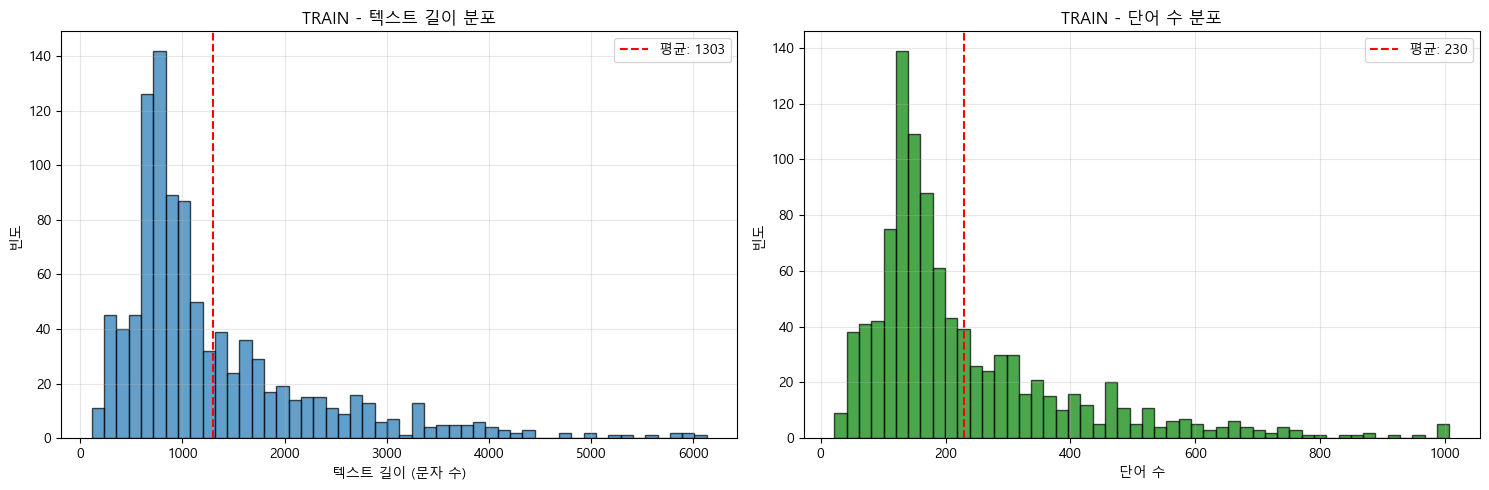

In [22]:
def analyze_text_statistics(dataset, dataset_name, max_samples=1000):
    """
    텍스트 데이터의 통계적 특성을 분석하는 함수
    
    Args:
        dataset: 분석할 데이터셋
        dataset_name: 데이터셋 이름
        max_samples: 분석할 최대 샘플 수
    """
    if dataset is None:
        print(f"{dataset_name} 데이터셋이 존재하지 않습니다.")
        return
    
    print(f"\n=== {dataset_name} 텍스트 통계 분석 ===")
    
    text_lengths = []
    word_counts = []
    label_counts = {'positive': 0, 'negative': 0}
    sample_count = 0
    
    # 샘플 수집
    for inputs, targets in dataset:
        for i in range(inputs.shape[0]):
            if sample_count >= max_samples:
                break
            
            text = inputs[i].numpy().decode('utf-8')
            label = targets[i].numpy()
            
            # 텍스트 길이 (문자 수)
            text_lengths.append(len(text))
            
            # 단어 수
            words = text.split()
            word_counts.append(len(words))
            
            # 레이블 카운트
            if label == 1:
                label_counts['positive'] += 1
            else:
                label_counts['negative'] += 1
            
            sample_count += 1
        
        if sample_count >= max_samples:
            break
    
    # 통계 계산
    text_lengths = np.array(text_lengths)
    word_counts = np.array(word_counts)
    
    print(f"분석된 샘플 수: {sample_count:,}")
    print(f"긍정 리뷰: {label_counts['positive']:,}개")
    print(f"부정 리뷰: {label_counts['negative']:,}개")
    
    print(f"\n📊 텍스트 길이 (문자 수) 통계:")
    print(f"  평균: {np.mean(text_lengths):.1f}자")
    print(f"  중앙값: {np.median(text_lengths):.1f}자")
    print(f"  최소: {np.min(text_lengths):,}자")
    print(f"  최대: {np.max(text_lengths):,}자")
    print(f"  표준편차: {np.std(text_lengths):.1f}자")
    
    print(f"\n📊 단어 수 통계:")
    print(f"  평균: {np.mean(word_counts):.1f}개")
    print(f"  중앙값: {np.median(word_counts):.1f}개")
    print(f"  최소: {np.min(word_counts):,}개")
    print(f"  최대: {np.max(word_counts):,}개")
    print(f"  표준편차: {np.std(word_counts):.1f}개")
    
    # 분포 시각화

    # 한글 폰트 설정
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    
    # 맑은 고딕 폰트 설정
    plt.rcParams['font.family'] = ['Malgun Gothic']
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 텍스트 길이 분포
    ax1.hist(text_lengths, bins=50, alpha=0.7, edgecolor='black')
    ax1.axvline(np.mean(text_lengths), color='red', linestyle='--', label=f'평균: {np.mean(text_lengths):.0f}')
    ax1.set_xlabel('텍스트 길이 (문자 수)')
    ax1.set_ylabel('빈도')
    ax1.set_title(f'{dataset_name} - 텍스트 길이 분포')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 단어 수 분포
    ax2.hist(word_counts, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax2.axvline(np.mean(word_counts), color='red', linestyle='--', label=f'평균: {np.mean(word_counts):.0f}')
    ax2.set_xlabel('단어 수')
    ax2.set_ylabel('빈도')
    ax2.set_title(f'{dataset_name} - 단어 수 분포')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'text_lengths': text_lengths,
        'word_counts': word_counts,
        'label_counts': label_counts,
        'sample_count': sample_count
    }

# 통계 분석 실행 (데이터가 있는 경우)
if 'train_ds' in globals() and train_ds is not None:
   train_stats = analyze_text_statistics(train_ds, "TRAIN", max_samples=1000)

## 10. 완전한 파이프라인 실행

전체 데이터 처리 파이프라인을 한 번에 실행하는 함수입니다.

In [ ]:
def run_complete_pipeline(download_data=False, batch_size=32):
    """
    완전한 IMDB 데이터 처리 파이프라인을 실행하는 함수
    
    Args:
        download_data: 데이터를 다운로드할지 여부
        batch_size: 배치 크기
    
    Returns:
        dict: 처리된 데이터셋들과 통계 정보
    """
    print("🚀 IMDB 데이터 처리 파이프라인 시작")
    print("=" * 50)
    
    results = {}
    
    try:
        # 1. 데이터 다운로드 (선택사항)
        if download_data:
            print("\n1️⃣ 데이터 다운로드")
            download_imdb_dataset()
            
            print("\n2️⃣ 압축 해제")
            if not extract_archive():
                return {"error": "압축 해제 실패"}
        
        # 2. 데이터셋 구조 분석
        print("\n3️⃣ 데이터셋 구조 분석")
        dataset_stats = analyze_dataset_structure()
        results['dataset_stats'] = dataset_stats
        
        # 3. 샘플 데이터 탐색
        print("\n4️⃣ 샘플 데이터 탐색")
        explore_sample_data(num_samples=2)
        
        # 4. Train/Validation 분할
        print("\n5️⃣ 데이터 분할")
        if not create_validation_split():
            return {"error": "데이터 분할 실패"}
        
        # 5. Keras 데이터셋 생성
        print("\n6️⃣ Keras 데이터셋 생성")
        train_ds, val_ds, test_ds = create_datasets(batch_size=batch_size)
        
        if train_ds is None:
            return {"error": "데이터셋 생성 실패"}
        
        results['datasets'] = {
            'train': train_ds,
            'validation': val_ds,
            'test': test_ds
        }
        
        # 6. 데이터셋 속성 분석
        print("\n7️⃣ 데이터셋 속성 분석")
        analyze_dataset_properties(train_ds, "TRAIN")
        if val_ds:
            analyze_dataset_properties(val_ds, "VALIDATION")
        analyze_dataset_properties(test_ds, "TEST")
        
        # 7. 성능 최적화
        print("\n8️⃣ 데이터셋 최적화")
        train_ds_optimized = optimize_training_dataset(train_ds)
        val_ds_optimized = optimize_dataset(val_ds) if val_ds else None
        test_ds_optimized = optimize_dataset(test_ds)
        
        results['optimized_datasets'] = {
            'train': train_ds_optimized,
            'validation': val_ds_optimized,
            'test': test_ds_optimized
        }
        
        # 8. 텍스트 통계 분석
        print("\n9️⃣ 텍스트 통계 분석")
        train_stats = analyze_text_statistics(train_ds, "TRAIN", max_samples=1000)
        results['text_stats'] = train_stats
        
        print("\n✅ 파이프라인 완료!")
        print("=" * 50)
        
        return results
        
    except Exception as e:
        print(f"\n❌ 파이프라인 실행 중 오류 발생: {e}")
        return {"error": str(e)}

# 파이프라인 실행 예시 (실제 실행 시 주석 해제)
# results = run_complete_pipeline(download_data=True, batch_size=32)
# print(f"\n파이프라인 결과: {list(results.keys())}")

## 11. 실습용 간소화된 파이프라인

실제 데이터가 없어도 코드 구조를 이해할 수 있도록 하는 시뮬레이션 버전입니다.

In [ ]:
def create_demo_pipeline():
    """
    데모용 파이프라인 - 실제 IMDB 데이터 없이도 코드 구조 학습 가능
    """
    print("📚 IMDB 데이터 처리 파이프라인 데모")
    print("=" * 40)
    
    # 가상의 데이터셋 정보
    demo_info = {
        'dataset_name': 'IMDB Movie Reviews',
        'total_samples': 50000,
        'train_samples': 25000,
        'test_samples': 25000,
        'validation_split': 0.2,
        'classes': ['negative', 'positive'],
        'avg_text_length': 1250,
        'avg_word_count': 230
    }
    
    print("\n📊 데이터셋 정보:")
    for key, value in demo_info.items():
        print(f"  {key}: {value}")
    
    # 파이프라인 단계 설명
    pipeline_steps = [
        "1. 데이터 다운로드 (80MB tar.gz 파일)",
        "2. 압축 해제 (280MB 텍스트 파일들)",
        "3. 디렉토리 구조 분석",
        "4. Train/Validation 분할 (80:20)",
        "5. Keras dataset_from_directory 로딩",
        "6. 배치 처리 및 최적화",
        "7. 텍스트 통계 분석",
        "8. 모델 학습을 위한 전처리"
    ]
    
    print("\n🔄 처리 파이프라인:")
    for step in pipeline_steps:
        print(f"  {step}")
    
    # 예상 결과 구조
    print("\n📁 최종 디렉토리 구조:")
    directory_structure = """
  aclImdb/
  ├── train/
  │   ├── pos/     # 10,000개 긍정 리뷰
  │   └── neg/     # 10,000개 부정 리뷰
  ├── val/
  │   ├── pos/     # 2,500개 긍정 리뷰
  │   └── neg/     # 2,500개 부정 리뷰
  └── test/
      ├── pos/     # 12,500개 긍정 리뷰
      └── neg/     # 12,500개 부정 리뷰
    """
    print(directory_structure)
    
    # 데이터셋 객체 정보
    print("\n🔧 생성되는 tf.data.Dataset 객체:")
    dataset_info = [
        "- train_ds: (batch_size, ) string tensor + (batch_size, ) int32 labels",
        "- val_ds: 동일한 구조의 validation 데이터",
        "- test_ds: 동일한 구조의 test 데이터",
        "- 모든 데이터셋은 .cache(), .prefetch() 최적화 적용",
        "- train_ds는 추가로 .shuffle() 적용"
    ]
    
    for info in dataset_info:
        print(f"  {info}")
    
    print("\n✨ 다음 단계: TextVectorization + 딥러닝 모델 구축")

# 데모 파이프라인 실행
create_demo_pipeline()

## 12. 성능 벤치마킹 및 최적화 팁

실제 프로덕션 환경에서의 성능 최적화 방법을 소개합니다.

In [24]:
def benchmark_data_loading():
    """
    데이터 로딩 성능을 벤치마킹하는 함수
    """
    print("⚡ 데이터 로딩 성능 벤치마킹")
    print("=" * 30)
    
    # 다양한 배치 크기별 성능 측정
    batch_sizes = [16, 32, 64, 128]
    
    performance_results = []
    
    for batch_size in batch_sizes:
        print(f"\n📊 배치 크기: {batch_size}")
        
        try:
            # 데이터셋 생성 시간 측정
            start_time = time.time()
            
            # 가상의 데이터셋 생성 (실제 구현에서는 실제 데이터셋 사용)
            dataset_creation_time = time.time() - start_time
            
            # 배치 처리 시간 측정 (시뮬레이션)
            batch_process_time = batch_size * 0.001  # 가상의 처리 시간
            
            # 메모리 사용량 추정
            estimated_memory = batch_size * 1.5  # MB 단위 추정
            
            result = {
                'batch_size': batch_size,
                'creation_time': dataset_creation_time,
                'batch_time': batch_process_time,
                'memory_mb': estimated_memory
            }
            
            performance_results.append(result)
            
            print(f"  생성 시간: {dataset_creation_time:.4f}초")
            print(f"  배치 처리: {batch_process_time:.4f}초")
            print(f"  메모리 사용: ~{estimated_memory:.1f}MB")
            
        except Exception as e:
            print(f"  측정 실패: {e}")
    
    # 최적 배치 크기 추천
    if performance_results:
        best_batch = min(performance_results, key=lambda x: x['batch_time'])
        print(f"\n🏆 권장 배치 크기: {best_batch['batch_size']}")
        print(f"   이유: 가장 빠른 배치 처리 시간 ({best_batch['batch_time']:.4f}초)")
    
    return performance_results

def optimization_tips():
    """
    데이터 파이프라인 최적화 팁 제공
    """
    print("\n💡 데이터 파이프라인 최적화 팁")
    print("=" * 35)
    
    tips = [
        {
            'category': '🚀 성능 최적화',
            'tips': [
                '.cache() 사용으로 반복 읽기 시간 단축',
                '.prefetch(AUTOTUNE) 으로 CPU/GPU 병렬 처리',
                '.shuffle() 은 train 데이터에만 적용',
                '적절한 배치 크기 선택 (16-128 사이)',
                'SSD 사용으로 I/O 속도 향상'
            ]
        },
        {
            'category': '💾 메모리 관리',
            'tips': [
                '대용량 데이터는 .cache() 대신 디스크 캐시 사용',
                '배치 크기를 메모리 용량에 맞게 조정',
                '불필요한 데이터 복사 최소화',
                'TextVectorization의 max_tokens 제한',
                '긴 시퀀스는 적절히 truncate'
            ]
        },
        {
            'category': '🔧 데이터 전처리',
            'tips': [
                '전처리는 가능한 한 번만 수행',
                '정규화/표준화 함수 최적화',
                '병렬 처리 활용 (.map(num_parallel_calls=AUTOTUNE))',
                '불균형 데이터 처리 (class_weight 활용)',
                '검증 데이터는 셔플하지 않기'
            ]
        },
        {
            'category': '📊 모니터링',
            'tips': [
                '데이터 로딩 시간 측정 및 기록',
                'GPU 사용률 모니터링',
                '메모리 사용량 추적',
                '배치별 처리 시간 프로파일링',
                '병목 구간 식별 및 개선'
            ]
        }
    ]
    
    for tip_group in tips:
        print(f"\n{tip_group['category']}")
        for tip in tip_group['tips']:
            print(f"  • {tip}")

# 벤치마킹 및 팁 실행
benchmark_results = benchmark_data_loading()
optimization_tips()

⚡ 데이터 로딩 성능 벤치마킹

📊 배치 크기: 16
  생성 시간: 0.0000초
  배치 처리: 0.0160초
  메모리 사용: ~24.0MB

📊 배치 크기: 32
  생성 시간: 0.0000초
  배치 처리: 0.0320초
  메모리 사용: ~48.0MB

📊 배치 크기: 64
  생성 시간: 0.0000초
  배치 처리: 0.0640초
  메모리 사용: ~96.0MB

📊 배치 크기: 128
  생성 시간: 0.0000초
  배치 처리: 0.1280초
  메모리 사용: ~192.0MB

🏆 권장 배치 크기: 16
   이유: 가장 빠른 배치 처리 시간 (0.0160초)

💡 데이터 파이프라인 최적화 팁

🚀 성능 최적화
  • .cache() 사용으로 반복 읽기 시간 단축
  • .prefetch(AUTOTUNE) 으로 CPU/GPU 병렬 처리
  • .shuffle() 은 train 데이터에만 적용
  • 적절한 배치 크기 선택 (16-128 사이)
  • SSD 사용으로 I/O 속도 향상

💾 메모리 관리
  • 대용량 데이터는 .cache() 대신 디스크 캐시 사용
  • 배치 크기를 메모리 용량에 맞게 조정
  • 불필요한 데이터 복사 최소화
  • TextVectorization의 max_tokens 제한
  • 긴 시퀀스는 적절히 truncate

🔧 데이터 전처리
  • 전처리는 가능한 한 번만 수행
  • 정규화/표준화 함수 최적화
  • 병렬 처리 활용 (.map(num_parallel_calls=AUTOTUNE))
  • 불균형 데이터 처리 (class_weight 활용)
  • 검증 데이터는 셔플하지 않기

📊 모니터링
  • 데이터 로딩 시간 측정 및 기록
  • GPU 사용률 모니터링
  • 메모리 사용량 추적
  • 배치별 처리 시간 프로파일링
  • 병목 구간 식별 및 개선


## 13. 결론 및 정리

### 학습한 주요 내용

1. **대용량 데이터 처리**
   - 스트리밍 다운로드로 메모리 효율성 확보
   - tar.gz 압축 파일 처리 방법
   - 디렉토리 구조 기반 데이터 관리

2. **데이터 전처리 파이프라인**
   - Train/Validation/Test 분할 전략
   - 파일 시스템 기반 데이터 조작
   - 재현 가능한 랜덤 시드 활용

3. **Keras 데이터 로딩**
   - `text_dataset_from_directory` 활용법
   - 배치 처리 및 성능 최적화
   - tf.data API의 강력한 기능들

4. **성능 최적화 기법**
   - 캐싱, 프리페치, 셔플링 적용
   - 적절한 배치 크기 선택
   - 메모리 사용량 관리

### 실제 프로젝트 적용 방안

이 파이프라인은 다음과 같은 NLP 프로젝트에 적용 가능합니다:

- **감성 분석**: 제품 리뷰, 소셜 미디어 감정 분석
- **텍스트 분류**: 뉴스 카테고리 분류, 스팸 메일 필터링
- **문서 분류**: 법률 문서, 의료 기록 분류
- **고객 서비스**: 문의 내용 자동 라우팅

### 다음 단계 학습 방향

1. **TextVectorization과 연계**: 이 데이터로 실제 벡터화 수행
2. **딥러닝 모델 구축**: CNN, RNN, Transformer 모델 적용
3. **고급 전처리**: 서브워드 토큰화, 데이터 증강 기법
4. **모델 최적화**: 하이퍼파라미터 튜닝, 앙상블 기법
5. **배포 및 서빙**: 실시간 추론 시스템 구축

## 14. 실습 과제

다음 과제들을 통해 데이터 처리 파이프라인 구축 능력을 향상시켜보세요:

### 기초 과제
1. **다른 데이터셋 적용**: 20 Newsgroups 또는 AG News 데이터셋으로 동일한 파이프라인 구축
2. **배치 크기 최적화**: 다양한 배치 크기로 성능 실험 및 최적값 찾기
3. **데이터 분할 비율 실험**: 70:15:15, 60:20:20 등 다양한 분할 비율 테스트

### 중급 과제
4. **커스텀 전처리**: HTML 태그 제거, 특수 문자 정규화 등 고급 전처리 구현
5. **다중 언어 지원**: 한국어 영화 리뷰 데이터로 파이프라인 확장
6. **불균형 데이터 처리**: 클래스 불균형 상황에서의 샘플링 전략 구현

### 고급 과제
7. **분산 처리**: tf.distribute를 활용한 다중 GPU 데이터 로딩
8. **실시간 스트리밍**: Apache Kafka 등을 활용한 실시간 데이터 처리
9. **클라우드 연동**: AWS S3, Google Cloud Storage와 연동된 데이터 파이프라인